In [31]:
import os 
import numpy as np
import h5py as h5
import nrrd
import fnmatch
import matplotlib.pyplot as plt
plt.rcParams['image.cmap'] = 'plasma'

from skimage.measure import label

In [32]:
def readH5(file_path,**kwargs):
    """
    generic function to read a h5 file with one 
    subgroup elements by given filepath in a Dictonary 
    """

    import h5py as h5
    
    out = {}

    with h5.File(file_path, 'r') as f:

        for key in f.keys():

            if isinstance(f[key],h5.Group):
                out[key] = {}
                for sub_key in f[key]:
                    out[key][sub_key] = f[key][sub_key][...]
            else:
                out[key] = f[key][:]
        f.close()
    return out

In [40]:
file_path   = "/Volumes/projects/pore-detection/prediction/Pinprobe_komplett.seg.vol.val.pred.h5"
assert os.path.exists(file_path)

In [41]:
file   = readH5(file_path)
for key, item in file.items():
    if isinstance(item, dict):
        print(key)
        for subkey, subitems in item.items():
            print(subkey,subitems.shape,subitems.dtype,subitems)
    else:
        print(key,item.shape,item.dtype)

predictions (833, 207, 802) uint8


In [5]:
file["instances"] = label(file["masks"][0,::],connectivity=2)

print(len(np.unique(file["instances"])))
print(len(np.unique(file["labels"])))

KeyError: 'masks'

In [42]:
for key, item in file.items():
    if isinstance(item, dict):
        print(key)
        for subkey, subitems in item.items():
            print(subkey,subitems.shape,subitems.dtype,subitems)
    else:
        print(key,item.shape,item.dtype)

predictions (833, 207, 802) uint8


[254 255]
[0 1]


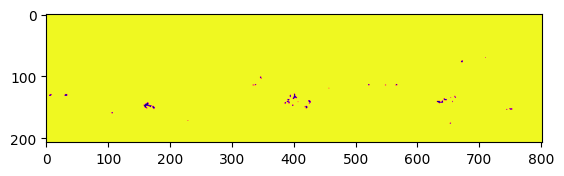

In [47]:
plt.imshow(~file["predictions"][50,::])
print(np.unique(file["predictions"]))

file["predictions"]=~file["predictions"]
print(np.unique(file["predictions"]))

In [44]:
def create_nrrd_header(size, spacing,space_origin, data_type='float', space='left-posterior-superior'):
    header = {
        'type': data_type,
        'dimension': len(size),
        'space dimension': len(size),
        'sizes': size,
        'space': space,
        'space origin': space_origin
    }

    if len(spacing) == len(size):
        header['space directions'] = np.diag(spacing).tolist()
        header['kinds'] = ['domain'] * len(size)

    header.update({
        'endian': 'little',
        'encoding': 'raw',
    })

    return header

In [45]:
def numpy_dtype_to_nrrd_dtype(dtype):
    """
    Convert NumPy dtype to NRRD dtype string.

    Parameters:
    - dtype: NumPy dtype object

    Returns:
    - NRRD dtype string
    """
    dtype_mapping = {
        np.uint8: 'uint8',
        np.uint16: 'uint16',
        np.uint32: 'uint32',
        np.uint64: 'uint64',
        np.int8: 'int8',
        np.int16: 'int16',
        np.int32: 'int32',
        np.int64: 'int64',
        np.float16: 'float16',
        np.float32: 'float32',
        np.float64: 'float64',
    }

    return dtype_mapping.get(dtype, 'unknown')

In [46]:
out_key_list = ["predictions"]

for key in out_key_list:

    if key == "raw":
        fileending = ".vol.nrrd"
    if key == "labels":
        fileending = ".gtruth.labels.nrrd"

    if key == "predictions":
        fileending = ".pred.labels.nrrd"

    fileout = os.path.basename(file_path).split('.')[0] + fileending
    
    print(fileout)


    data_type_seg = file[key].dtype
    size = file[key].shape

    spacing = (1,1,1)
    space_origin = (0 , 0 , 0 )

    header = create_nrrd_header(size, spacing, space_origin, data_type_seg)
    nrrd.write(fileout, file[key],header=header)


Pinprobe_komplett.pred.labels.nrrd


In [ ]:
n = len(data.keys())
fig, axs = plt.subplots(1,n,figsize=(n*3.5,3.5))

axs = np.array(axs).flatten()
for ax in axs: ax.axis("off")

slice = 30

# axs[0].imshow(data["raw"][:,:,slice],cmap="grey")
axs[0].imshow(data["labels"][:,:,slice])

In [ ]:
obj_ids = np.unique(data["labels"])

print(len(obj_ids))

obj_ids = obj_ids[0:]
data["masks"] = data["labels"] == obj_ids[:, None, None, None]

for key, item in data.items():
    if isinstance(item, dict):
        print(key,":")
        for subkey, subitems in item.items():
            print("\t",subkey,subitems.shape,subitems.dtype,subitems)
    else:
        print(key,item.shape,item.dtype)


In [ ]:
labels = np.zeros((2,*data["labels"].shape))

for cls in range(1,data["masks"].shape[0]):
    labels[cls-1] = label(data["masks"][cls,::],connectivity=2)

    plt.imshow(labels[cls-1,:,:,slice])
    plt.show()

data["labels"] = labels.astype(np.int16)

print(data["labels"].dtype)


In [ ]:
labels = label(data["masks"][1,::],connectivity=2)

print(len(np.unique(labels)))

plt.imshow(labels[50,::],cmap="plasma")

In [ ]:
data_type_seg = data["raw"].dtype
size = data["raw"].shape

spacing = (1,1,1)
space_origin = (0 , 0 , 0 )

header = create_nrrd_header(size, spacing, space_origin, data_type_seg)

fileout = os.path.basename(file_path).split('.')[0]
print(fileout)

In [ ]:
nrrd.write(os.path.join(fileout + ".vol"+ ".nrrd"), data["raw"],header=header)
nrrd.write(os.path.join(fileout + ".label"+ ".nrrd"), data["labels"],header=header)
nrrd.write(os.path.join(fileout + ".labels"+ ".nrrd"), labels,header=header)


# for i,cls in enumerate(["weft","fill"]):  
#     nrrd.write(os.path.join(fileout + f".{cls}" +".pred"+ ".nrrd"), data["labels"][i,::],header=header_seg)

In [ ]:
found_first_item = False
for root, dirs, files in os.walk(src_path):

    for dir_name in dirs:
        # print(dir_name)
        if "rand_subvolume" in dir_name.lower():
            # print(dir_name)
            print(os.listdir(os.path.join(root,dir_name)))
            for file in fnmatch.filter(os.listdir(os.path.join(root,dir_name)),"*.h5"):
                
                print(os.path.join(root,dir_name,file))
                file_path = os.path.join(root,dir_name,file)

                data = readH5(file_path)

                data_type = data["raw"].dtype
                size = data["raw"].shape
                spacing = ( data["volume_data"]["VoxelSizeX"],
                            data["volume_data"]["VoxelSizeX"],
                            data["volume_data"]["VoxelSizeX"]
                            )

                space_origin = data["volume_data"]["Origin"]*spacing
                print(data_type,len(size),spacing,space_origin)


                header = create_nrrd_header(size, spacing, space_origin, data_type)
                fileout = os.path.splitext(file)[0]


                nrrd.write(os.path.join(root,dir_name,fileout + ".nrrd"), data["raw"],header=header)
                


                found_first_item = False
                
        if found_first_item:
            break
    if found_first_item:
            break        